In [1160]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import os
import re

In [1161]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())


2.7.1+cpu
False


In [1162]:


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device




device(type='cpu')

In [1163]:
import re

def normalize_text(text: str) -> str:
    # Convert to lowercase
    text = text.lower()
    
    # Replace dates (dd/mm/yyyy or yyyy-mm-dd) with <DATE>
    text = re.sub(r'\b\d{1,2}[/-]\d{1,2}[/-]\d{2,4}\b', '<DATE>', text)
    text = re.sub(r'\b\d{4}[/-]\d{1,2}[/-]\d{1,2}\b', '<DATE>', text)
    
    # Replace currency amounts ($, €, ₹, £, etc.) with <CUR>
    text = re.sub(r'[\$€₹£]\s*\d+(\.\d+)?', '<CUR>', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s<>]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    # Replace all standalone numbers with <NUM>
    text = re.sub(r'\b\d+(\.\d+)?\b', '<NUM>', text)
    
    return text


In [1164]:
# Get current working directory (where Jupyter is running)
cwd = os.getcwd()

# Build the correct path relative to your notebook
csv_path = os.path.join(cwd, "..", "data", "text_cat2.csv")

# Normalize the path (resolves ..)
csv_path = os.path.abspath(csv_path)

print("CSV Path:", csv_path)

df = pd.read_csv(csv_path)
# Extract columns
df["text"] = df["text"].apply(normalize_text)
texts = df['text']
labels = df['category']

CSV Path: d:\Programming\Projects\Finance-Tracker-App\backend\data\text_cat2.csv


In [1165]:
#converting text data into numerical vectors
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(texts)
X.shape


(1035, 487)

In [1166]:
# Encoding the labels
encoder = LabelEncoder()
y = encoder.fit_transform(labels)
y

array([2, 5, 4, ..., 1, 1, 1])

In [1167]:
#Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert sparse matrices to dense arrays to avoid type errors
X_train = X_train.toarray()
X_test = X_test.toarray()


X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)


In [1168]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)


In [1169]:
#Define model
class ExpenseClassifier(nn.Module):
    def __init__(self, input_size,hidden_size, num_classes):
        super(ExpenseClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self,x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

In [1170]:
X_train.shape[1]

487

In [1171]:
input_size = X_train.shape[1]
hidden_size = 128
num_classes = len(set(y))

model = ExpenseClassifier(input_size, hidden_size, num_classes)
model.to(device)

ExpenseClassifier(
  (fc1): Linear(in_features=487, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)

In [1172]:
#Loss and optimizer
criterion = nn.CrossEntropyLoss() # compares predicted catgeory vs actual
optimizer = optim.Adam(model.parameters(), lr=0.01) # updates model weights efficiently


Epoch [50/500] | Train Loss: 0.0004, Acc: 1.0000 | Test Loss: 0.3785, Acc: 0.8454
Epoch [100/500] | Train Loss: 0.0002, Acc: 1.0000 | Test Loss: 0.3834, Acc: 0.8454
Epoch [150/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3862, Acc: 0.8454
Epoch [200/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3884, Acc: 0.8454
Epoch [250/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3904, Acc: 0.8502
Epoch [300/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3921, Acc: 0.8502
Epoch [350/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3937, Acc: 0.8502
Epoch [400/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3951, Acc: 0.8502
Epoch [450/500] | Train Loss: 0.0001, Acc: 1.0000 | Test Loss: 0.3965, Acc: 0.8502
Epoch [500/500] | Train Loss: 0.0000, Acc: 1.0000 | Test Loss: 0.3980, Acc: 0.8502


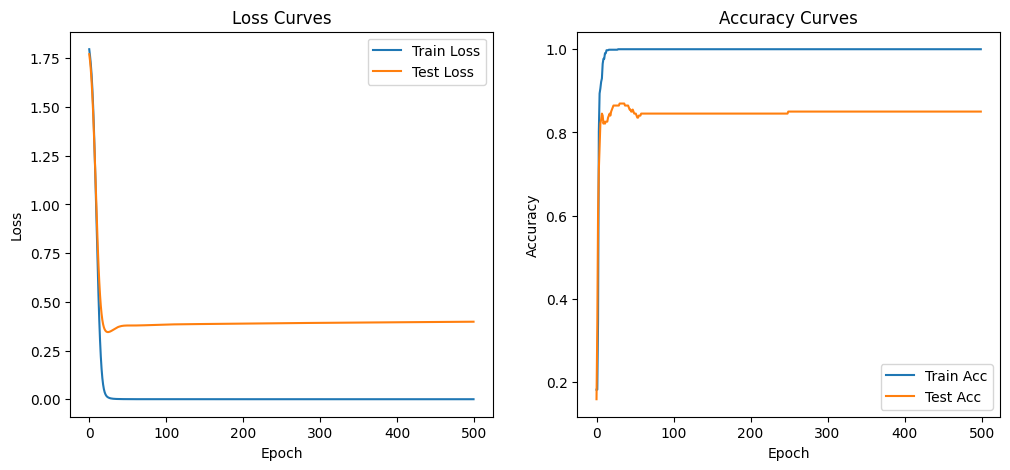

In [1173]:
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [],[]
import matplotlib.pyplot as plt
epochs = 500
for epoch in range(epochs):
    # ---- TRAIN ----
    model.train()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Train metrics
    train_losses.append(loss.item())
    _, predicted = torch.max(outputs, 1)
    train_acc = (predicted == y_train).float().mean().item()
    train_accuracies.append(train_acc)

    # ---- TEST ----
    model.eval()
    with torch.inference_mode():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_losses.append(test_loss.item())

        test_pred = torch.argmax(test_outputs, dim=1)
        test_acc = (test_pred == y_test).float().mean().item()
        test_accuracies.append(test_acc)

    if (epoch + 1) % 50 == 0:  # log every 50 epochs
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"| Train Loss: {loss.item():.4f}, Acc: {train_acc:.4f} "
              f"| Test Loss: {test_loss.item():.4f}, Acc: {test_acc:.4f}")

# ---- PLOTS ----
plt.figure(figsize=(12,5))

# Loss
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curves")
plt.legend()

# Accuracy
plt.subplot(1,2,2)
plt.plot(train_accuracies, label="Train Acc")
plt.plot(test_accuracies, label="Test Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy Curves")
plt.legend()

plt.show()


In [1174]:
#Evaluation
with torch.inference_mode():
    y_pred = model(X_test) #forward pass
    y_pred_classes = torch.argmax(y_pred, dim=1 ) #pick highest probability class
    acc = (y_pred_classes == y_test).float().mean() #accuracy
    print(f'Accuracy: {acc.item():.4f}')

Accuracy: 0.8502


In [1175]:
import torch
import joblib
import os

save_dir = "."   # current directory (your models folder)
os.makedirs(save_dir, exist_ok=True)

# Save TF-IDF vectorizer
joblib.dump(vectorizer, os.path.join(save_dir, "vectorizer.pkl"))

# Save model weights
torch.save(model.state_dict(), os.path.join(save_dir, "category_predictor_model.pth"))

# Save category mapping using PyTorch (from the LabelEncoder)
category_list = list(encoder.classes_)  # this preserves exact order
torch.save(category_list, os.path.join(save_dir, "encoder.pth"))


In [1176]:
# import spacy
# nlp = spacy.load("en_core_web_sm")
totals = {category: 0.0 for category in encoder.classes_}
totals["Others"] = 0.0

import torch.nn.functional as F

def predict(text, threshold=0.7):
    # Vectorize
    text = normalize_text(text)
    vec = vectorizer.transform([text]).toarray()
    vec = torch.tensor(vec, dtype=torch.float32).to(device)

    # Predict probabilities
    output = model(vec)
    probs = F.softmax(output, dim=1)
    max_prob, pred_idx = torch.max(probs, dim=1)

    # Decide category
    if max_prob.item() < threshold:
        pred_category = "Others"
    else:
        pred_category = encoder.inverse_transform([pred_idx.item()])[0]
    print(f"Predicted category: {pred_category} with probability {max_prob.item():.4f}")
    return pred_category


    # # Extract all amounts
    # doc = nlp(text)
    # amount = 0.0
    # for ent in doc.ents:
    #     if ent.label_ in ["MONEY", "CARDINAL"]:
    #         try:
    #             amount += float(ent.text)  # sum all numbers in the sentence
    #         except:
    #             pass

    # totals[pred] += amount
    # return totals
# testing:
predict("Bought apples for 80 rs")   
predict("Hospital bill as 750")   
predict("Taxi fare as 300")       
predict("Netflix subscription as 500") 
predict("Train from Velachery as 150") 
predict("Spent 500 for spinach")
predict("Spent 500000 on sons tuition fee")
predict("Spent 5 rs on train")
predict("spent 500 on uber")
predict("5000 rs for groceries")
predict("Movie ticket 250")
predict("uber ride for 500rs")


Predicted category: Food with probability 1.0000
Predicted category: Healthcare with probability 0.9845
Predicted category: Transport with probability 0.9973
Predicted category: Entertainment with probability 0.9941
Predicted category: Transport with probability 0.9095
Predicted category: Food with probability 1.0000
Predicted category: Education with probability 0.9929
Predicted category: Transport with probability 0.9095
Predicted category: Transport with probability 0.7980
Predicted category: Food with probability 0.9985
Predicted category: Entertainment with probability 0.9831
Predicted category: Transport with probability 1.0000


'Transport'

In [1177]:
# import spacy
# nlp = spacy.load("en_core_web_sm")

# doc = nlp("I spent Rs. 700 and 300 on food on 26th July")
# for ent in doc.ents:
#     print(ent.text, ent.label_)


In [1178]:
import os
print(os.getcwd())



d:\Programming\Projects\Finance-Tracker-App\backend\models


In [1179]:
print("Training order:", list(encoder.classes_))





Training order: ['Education', 'Entertainment', 'Food', 'Healthcare', 'Housing', 'Transport']
